<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [39]:
# Import libraries for data wrangling, preprocessing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import keras.utils
from keras import utils as np_utils

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [25]:
# Importing libraries for building the neural network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

Read in file

In [26]:
from google.colab import files
uploaded = files.upload()
dataset = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full (3).csv


Data Exploration

Unique values of the target variable [0 1]
Counts of the target variable : [36548  4640]
Examples:
    Total: 41188
    Yes: 4640 (11.27% of total)



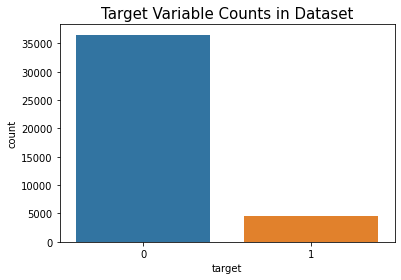

In [27]:
dataset.rename(columns = {'y':'target'}, inplace = True)
dataset['target'] = dataset.target.apply(lambda x: 1 if x == "yes" else 0)

(unique, counts) = np.unique(dataset['target'], return_counts=True)

neg = counts[0]
pos = counts[1]
total = neg + pos
print('Unique values of the target variable', unique)
print('Counts of the target variable :', counts)
print('Examples:\n    Total: {}\n    Yes: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

sns.countplot(data = dataset,x = 'target')
plt.title('Target Variable Counts in Dataset')
plt.show()

Turn categories to numerical

In [28]:
dataset.info()

dataset['job'] = pd.factorize(dataset['job'])[0] + 1
dataset['marital'] = pd.factorize(dataset['marital'])[0] + 1
dataset['education'] = pd.factorize(dataset['education'])[0] + 1
dataset['default'] = pd.factorize(dataset['default'])[0] + 1
dataset['housing'] = pd.factorize(dataset['housing'])[0] + 1
dataset['default'] = pd.factorize(dataset['default'])[0] + 1
dataset['loan'] = pd.factorize(dataset['loan'])[0] + 1
dataset['contact'] = pd.factorize(dataset['contact'])[0] + 1
dataset['month'] = pd.factorize(dataset['month'])[0] + 1
dataset['day_of_week'] = pd.factorize(dataset['day_of_week'])[0] + 1
dataset['poutcome'] = pd.factorize(dataset['contact'])[0] + 1

# Should remove - duration as only for benchmark
dataset = dataset.drop('duration', 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

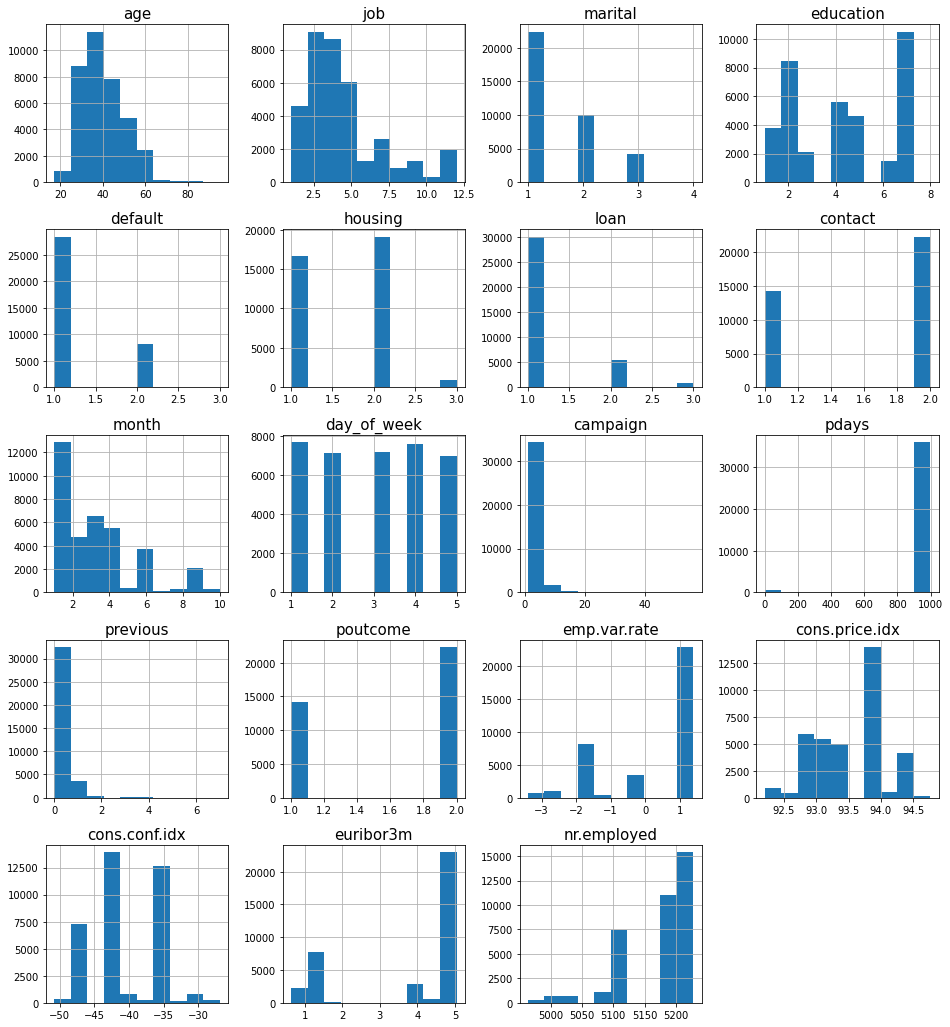

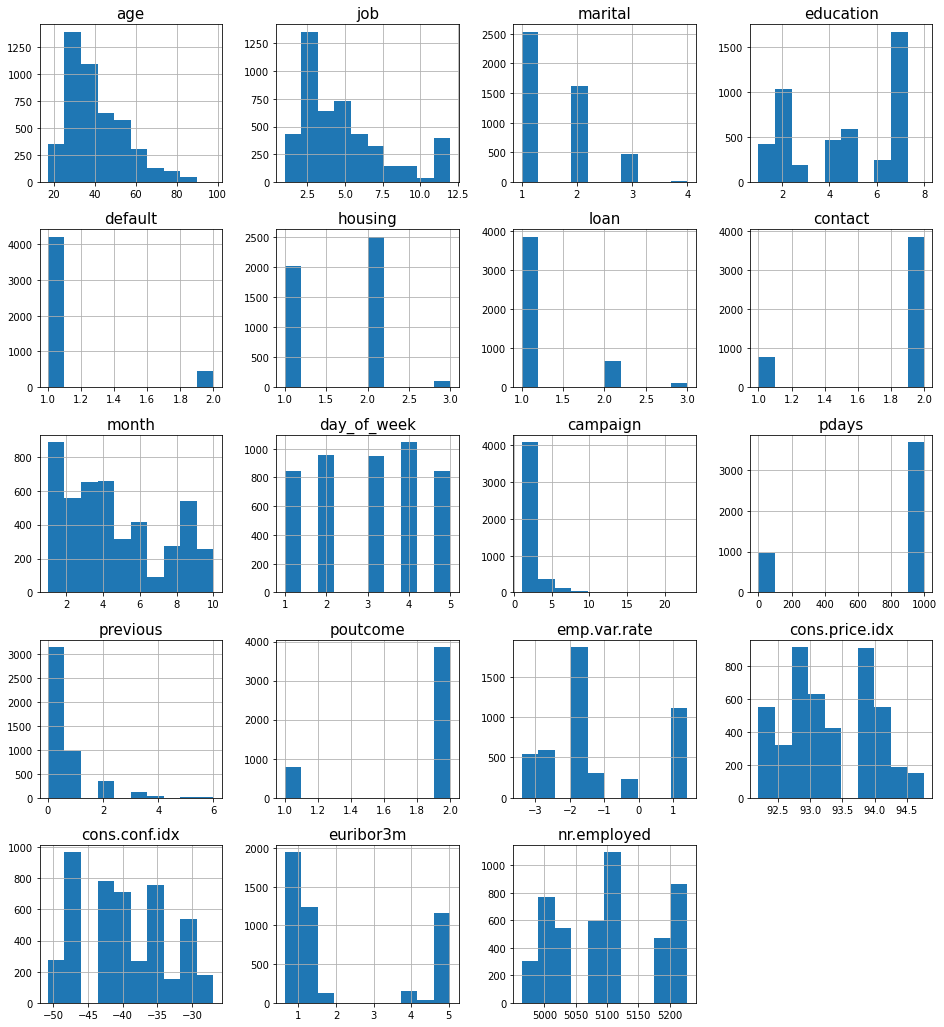

In [29]:
dataset.groupby('target').hist(figsize = (16,18))

dataset['previously_contacted'] = dataset.pdays.apply(lambda x: 0 if x == 999 else 1)
dataset = dataset.drop('pdays', 1)

# dataset.groupby('target').pdays.hist(alpha=0.4)

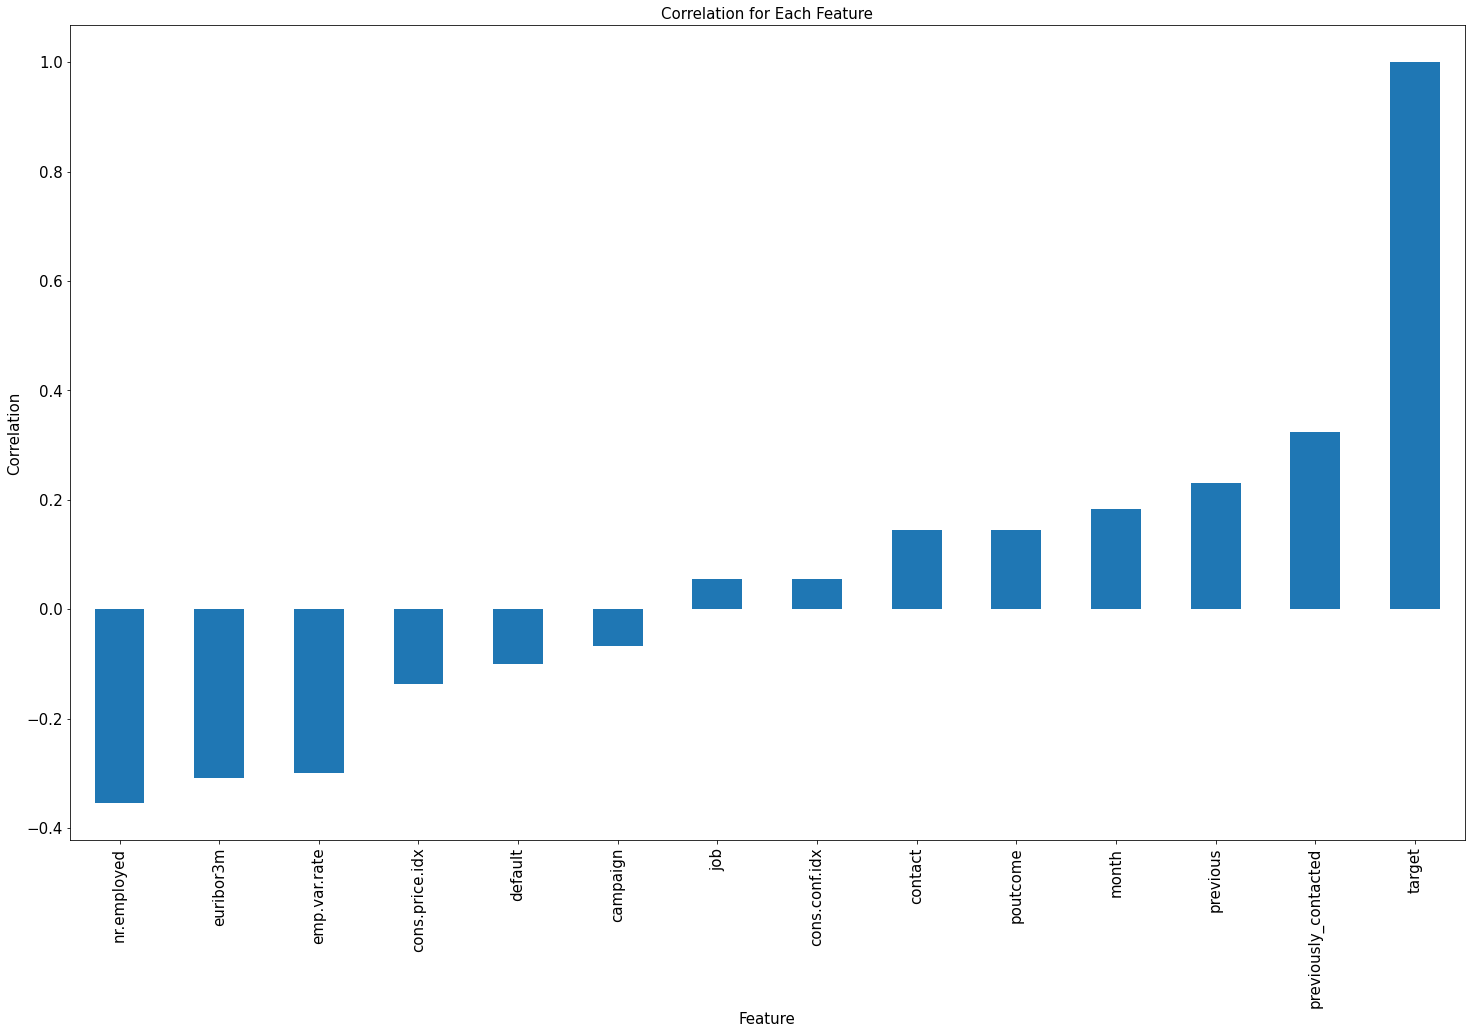

In [100]:
std_features_keep = dataset

# Create correlation matrix
corr_matrix = std_features_keep.corr()['target'].sort_values()
threshold = 0.05

for  i, v in corr_matrix.iteritems():
    if(abs(v) < threshold):
      std_features_keep = std_features_keep.drop(i, axis=1)

# Plot for correlation
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
std_plot = (std_features_keep.corr()['target'].sort_values()).plot(kind="bar",figsize=(25,15))
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Correlation for Each Feature')
plt.show()

In [101]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(std_features_keep, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('target'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('target'))
test_labels = np.array(test_df.pop('target'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [102]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (26360,)
Validation labels shape: (6590,)
Test labels shape: (8238,)
Training features shape: (26360, 13)
Validation features shape: (6590, 13)
Test features shape: (8238, 13)


In [103]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

Intial Model

In [104]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()

results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
print("pos:  " + str(pos))
print("neg:  " + str(neg))

Loss: 1.9713
pos:  4640
neg:  36548


Applying Intial Bias

Loss: 0.3570


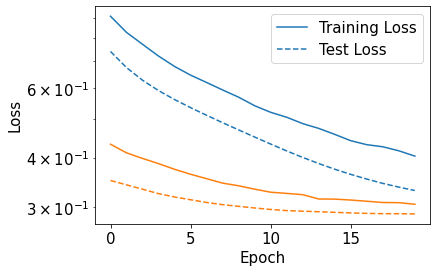

In [105]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

initial_bias = np.log([pos/neg])

model = make_model(output_bias=initial_bias)
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.legend(["Training Loss", "Test Loss"])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [106]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
13/13 [==============================] - 2s 61ms/step - loss: 0.4365 - accuracy: 0.8629 - precision: 0.3042 - recall: 0.1699 - auc: 0.5876 - prc: 0.1963 - val_loss: 0.3498 - val_accuracy: 0.8859 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6130 - val_prc: 0.1730
Epoch 2/100
13/13 [==============================] - 0s 7ms/step - loss: 0.4118 - accuracy: 0.8644 - precision: 0.2940 - recall: 0.1491 - auc: 0.5614 - prc: 0.1915 - val_loss: 0.3406 - val_accuracy: 0.8859 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6594 - val_prc: 0.2047
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.4025 - accuracy: 0.8676 - precision: 0.2992 - recall: 0.1346 - auc: 0.5581 - prc: 0.1890 - val_loss: 0.3320 - val_accuracy: 0.8859 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6998 - val_prc: 0.2422
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.3876 - accuracy: 0.8709 - precision: 0.

In [107]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('% right for no: ', cm[0][0]/(cm[0][0] + cm[0][1]))
  print('% right for yes: ', cm[1][1]/(cm[1][1] + cm[1][0]))

loss :  0.2819296717643738
accuracy :  0.8987618088722229
precision :  0.7058823704719543
recall :  0.18025751411914825
auc :  0.7907500267028809
prc :  0.44779640436172485

% right for no:  0.9904188338352039
% right for yes:  0.18025751072961374


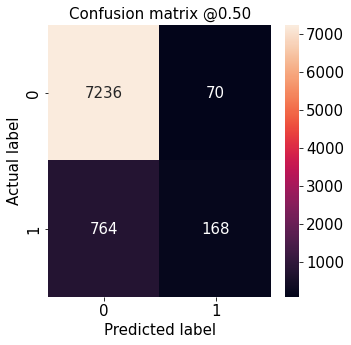

In [108]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

Weight for class 0: 0.56
Weight for class 1: 4.44
Epoch 1/100
13/13 [==============================] - 2s 61ms/step - loss: 1.0732 - accuracy: 0.8539 - precision: 0.2872 - recall: 0.2024 - auc: 0.6140 - prc: 0.2115 - val_loss: 0.3619 - val_accuracy: 0.8798 - val_precision: 0.3660 - val_recall: 0.0746 - val_auc: 0.6708 - val_prc: 0.2111
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.9829 - accuracy: 0.8187 - precision: 0.2384 - recall: 0.2807 - auc: 0.5985 - prc: 0.2008 - val_loss: 0.3841 - val_accuracy: 0.8601 - val_precision: 0.3333 - val_recall: 0.2277 - val_auc: 0.7096 - val_prc: 0.2428
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.9034 - accuracy: 0.7988 - precision: 0.2349 - recall: 0.3517 - auc: 0.6275 - prc: 0.2144 - val_loss: 0.4183 - val_accuracy: 0.8070 - val_precision: 0.2775 - val_recall: 0.4328 - val_auc: 0.7286 - val_prc: 0.2642
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.8455 - accura

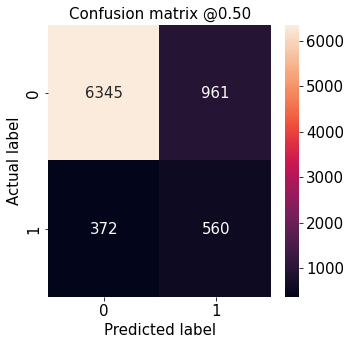

In [109]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = ((1 / neg) * (total / 2.0)) 
weight_for_1 = ((1 / pos) * (total / 2.0))

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

train_predictions_baseline = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

baseline_results = weighted_model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)



Oversampling

In [93]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

In [94]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/1000
20/20 [==============================] - 3s 102ms/step - loss: 0.8970 - accuracy: 0.5455 - precision: 0.4775 - recall: 0.5110 - auc: 0.5457 - prc: 0.5248 - val_loss: 0.7367 - val_accuracy: 0.4634 - val_precision: 0.1137 - val_recall: 0.5650 - val_auc: 0.5723 - val_prc: 0.2038
Epoch 2/1000
20/20 [==============================] - 1s 62ms/step - loss: 0.7726 - accuracy: 0.5529 - precision: 0.5492 - recall: 0.5832 - auc: 0.5777 - prc: 0.6319 - val_loss: 0.6879 - val_accuracy: 0.7528 - val_precision: 0.2475 - val_recall: 0.6019 - val_auc: 0.7034 - val_prc: 0.3105
Epoch 3/1000
20/20 [==============================] - 1s 60ms/step - loss: 0.6948 - accuracy: 0.6149 - precision: 0.6189 - recall: 0.6044 - auc: 0.6463 - prc: 0.6918 - val_loss: 0.6460 - val_accuracy: 0.7534 - val_precision: 0.2599 - val_recall: 0.6621 - val_auc: 0.7624 - val_prc: 0.3724
Epoch 4/1000
20/20 [==============================] - 1s 60ms/step - loss: 0.6621 - accuracy: 0.6420 - precision: 0.6592 - recall: 0

loss :  0.5428271293640137
accuracy :  0.7613498568534851
precision :  0.26793622970581055
recall :  0.6590414047241211
auc :  0.7753269076347351
prc :  0.39790448546409607

% right for no:  0.7741803278688525
% right for yes:  0.659041394335512


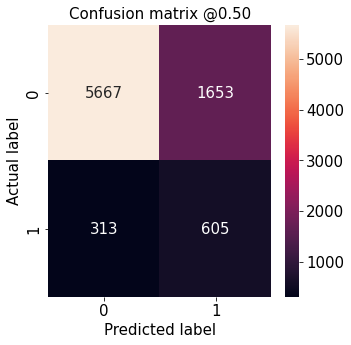

In [95]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Visualizing Neural Networks

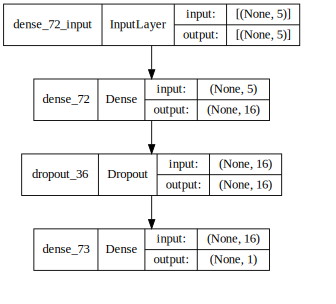

In [70]:
from IPython.display import SVG
import tensorflow as tf
from keras.utils.vis_utils import model_to_dot


SVG(model_to_dot(resampled_model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))